In [ ]:
!mkdir data    #load dataset
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip -P data/
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip -P data/
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip -P data/
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip -P data/
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -P data/
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip -P data/

--2022-01-19 18:37:15--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip [following]
--2022-01-19 18:37:16--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925390592 (883M) [application/zip]
Saving to: ‘data/DIV2K_train_LR_bicubic_X2.zip’

DIV2K_train_LR_bicu 100%[===================>] 882.52M  30.0MB/s    in 31s     

2022-01-19 18:37:47 (28.5 MB/s) - ‘data/DIV2K_train_LR_bicubic_X2.zip’ saved [925390592/925390592]

--2022-01-19 18:37:47--  http://data.vision.ee.ethz.ch

In [ ]:
import zipfile   #import zip dile
with zipfile.ZipFile('data/DIV2K_valid_LR_bicubic_X2.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')      #extract to data
with zipfile.ZipFile('data/DIV2K_train_LR_bicubic_X2.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')
with zipfile.ZipFile('data/DIV2K_valid_LR_bicubic_X4.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')
with zipfile.ZipFile('data/DIV2K_train_LR_bicubic_X4.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')
with zipfile.ZipFile('data/DIV2K_train_HR.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')
with zipfile.ZipFile('data/DIV2K_valid_HR.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
import torch
import torch.nn as nn

In [ ]:
# for the loading images
import torchvision
import matplotlib.pyplot as plt
import os
from torch.nn.functional import interpolate

low_train_direcory = 'data/DIV2K_train_LR_bicubic/X4'  
high_train_direcory = 'data/DIV2K_train_HR'   

# This function will load images from folders, and will return a 4d tensor. 
# The first dimention is the number of images, second is number of channels (3 for RGB), and the last two are height and width of images.
def load_images(direcory, h, w, num_images=100): 
    file_names = sorted(os.listdir(direcory))
    
    batches = torch.zeros(num_images, 3, h, w, dtype=torch.uint8) #establish 4d-tensor to load images: (100, 3, h, w) => 100 images, 3 channels(RGB), height and width
    for j in range(0, num_images):   
        # read the image from the direcory
        tsr_img = torchvision.io.read_image(os.path.join(direcory, file_names[j]))      # read 3-channel pic
               
        # preprocess: resize the pic to uniform size[h, w]
        tsr_img = interpolate(tsr_img[None, :].type(torch.FloatTensor), [h, w], mode='bicubic', align_corners=True)[0]     
        batches[j]=tsr_img.clamp(min=0, max=255).type(torch.float)          # batch appended in batches tensor
        tsr_img=None
    return batches        #return  batches tensor (num of images, 3 , h, w)    
  

In [ ]:
#h, w = 1356, 2040   
h_lr, w_lr = 339, 510        #all low resolution(lr) images will be resized to 339 and 510
h_hr, w_hr = 1356, 2040         #all high resolution(hr) images will be resized to 1356 and 2040

lr_batches = load_images(low_train_direcory, h_lr, w_lr).type(torch.float)
hr_batches = load_images(high_train_direcory, h_hr, w_hr).type(torch.float)

'torch.FloatTensor'

In [ ]:
# test batches shape:
print('low resolution shape: ' + str(lr_batches.shape))   #
print('high resolution shape: ' + str(hr_batches.shape))

low resolution shape: torch.Size([100, 3, 339, 510])
high resolution shape: torch.Size([100, 3, 1356, 2040])


In [ ]:
# train & test

N_train = int(0.8 * lr_batches.shape[0])   #80% train 20% test, split based on 1st dimension
# Mention that lr is as feature, or to-be-processsed pics, hr is as target  
x_train = lr_batches[:N_train,:]  # 80 images
y_train = hr_batches[:N_train]   #
x_val = lr_batches[N_train:,:]   # 20 images
y_val = hr_batches[N_train:]
print('x_val shape:'+ str(x_val.shape))     #test val shape
print('y_val shape:'+ str(y_val.shape))
train_num=x_train.shape[0]      
val_num=x_val.shape[0]
print('train_samples_num:', train_num)
print('val_samples_num:', val_num)

x_val shape:torch.Size([20, 3, 339, 510])
y_val shape:torch.Size([20, 3, 1356, 2040])
train_samples_num: 80
val_samples_num: 20


In [ ]:
# create Dataset object to support batch training
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features             
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

In [ ]:

class SRCNN(nn.Module):
    def __init__(self, upscale_factor):  
        super(SRCNN, self).__init__()   #Below conv layers based on the paper

        # first two layers of srcnn referenced :1. article [2014] SRCNN , 2. lab4   
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)    #padding=9//2, stride=1, bias=True, pads the input so the output has the shape as the input
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)  #padding=1//2, stride=1, bias=True, pads the input so the output has the shape as the input
        self.relu = nn.ReLU(inplace=True)   #we used inplace to reduce memory usage
        
        # (upscale_factor**2)*3 : *3 means 3 channels images(RGB)
        self.conv3 = nn.Conv2d(32, (upscale_factor**2)*3, kernel_size=1,padding=0)       # used for sub-pixel
                                                    #sub-pixel referenced 1. article [2016] , 2. https://blog.csdn.net/qq_41573860/article/details/117474254
                                      
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor) # used for sub_pixel
        
    def forward(self, x):                  
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))                                             
        x= self.conv3(x)
        x = self.pixel_shuffle(x)  
        return x         

In [ ]:
def compute_psnr(predictions,labels):    #compute_psnr
    # Here we use mse to help compute psnr
    criterion = torch.nn.MSELoss( reduction='mean')  #assign MSELoss function to criterion
    mse = criterion(predictions, labels)
    return 10. * torch.log10(255**2. / mse)    

In [ ]:
# train model:
import copy

def train_model(optimizer, learning_rate, num_epochs): 
    #Settings for training model:
    model = SRCNN(upscale_factor = 4)
    criterion = torch.nn.MSELoss( reduction='mean')
    optimizer = optimizer(model.parameters(),lr=learning_rate)  
    batch_size = 1 # batch size is 1 to avoid out of memory error.   
    # Load train set, batch size as 1 (namely an image per batch):
    train_dataset = Dataset(x_train, y_train) #(80 images) Dataset object deifned above, namely got X_train as features, Y_train as labels 
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)

    # To compute psnrs for predictions and targets on val dataset:  
    best_psnr_epo = np.zeros(val_num) 
    epos_psnr_avg = np.zeros(num_epochs)  
    best_avg_psnr = -1
    # Train model on train set:
    for i_epoch in range(num_epochs):
         model.train()
         # Although here use "labels","predictions", but actually just one label, one prediction each time as 1 pic per batch
         for i_batch, (x_batch, labels) in enumerate(train_dataloader):   #Here x_batch actually is x_train, labels is y_train
            model.zero_grad()  # reset model gradients before starting to do backpropragation 
            predictions = model(x_batch)  # conduct forward pass          
            loss = criterion(predictions, labels)                             
            loss.backward()  # backpropogate loss to calculate gradients   
            optimizer.step()       
 
         psnr_epo = np.zeros(val_num)
         #Test model on val set:
         with torch.no_grad():  # no need to calculate gradients when assessing psnr   
              model.eval()
              for i in range(val_num):
                  val_predictions = model(x_val[i][None, :]).clamp(0, 255)  
                  psnr_epo[i] = compute_psnr(val_predictions[0], y_val[i])

                
              # Calculate the average psnr for the current epoch.
              avg_psnr = (sum(psnr_epo) / val_num)
              epos_psnr_avg[i_epoch] = avg_psnr
              # in each epoch, we will check whether it is the best model or not, if yes, we will save the weights of the best epoch.
              if best_avg_psnr < avg_psnr:
                  best_psnr_epo = psnr_epo # the current psnr vector is the best.
                  best_avg_psnr = avg_psnr
                  # save weights into best_model.weight file.
                  torch.save(copy.deepcopy(model.state_dict()), 'best_model.weight') # we used copy.deepcopy to remove the link to model.

    return best_psnr_epo, epos_psnr_avg   #return psnr vector for val set and psnr vector for epochs

In [ ]:
print('x_val shape:'+ str(x_val.shape))
print('y_val shape:'+ str(y_val.shape))

x_val shape:torch.Size([20, 3, 339, 510])
y_val shape:torch.Size([20, 3, 1356, 2040])


In [ ]:
 # use plain bicubic, then compute psnr               
psnr_bicubic=np.zeros(val_num)   #initialize psnr vector for plain bicubic on val set
for i in range(val_num):   # 20 images
    image=x_val[i]                             
    image = interpolate(image[None, :].type(torch.FloatTensor), scale_factor=4, mode='bicubic', align_corners=True)[0] #plain bicubic on each lr image
    image=image.clamp(min=0, max=255)       #clamp result within    
    psnr_bicubic[i] = compute_psnr(image, y_val[i])        # compute psnr of plain-bicubiced lr image and target(namely hr image)
print(image.shape)    #test now the lr shape a bit 
print((sum(psnr_bicubic) / val_num))

torch.Size([3, 1356, 2040])
26.345621013641356


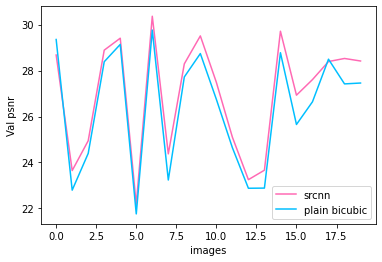

In [ ]:
val_psnr, epos_psnr_avg  = train_model(optimizer = torch.optim.Adam, learning_rate=0.001, num_epochs=70)  #get psnr via srcnn model 
plt.plot(val_psnr, color='hotpink')     
plt.plot(psnr_bicubic, color='deepskyblue')  
plt.xlabel('images') 
plt.ylabel('Val psnr')
labels=['srcnn','plain bicubic']
plt.legend(labels, loc = 'best')
plt.show()

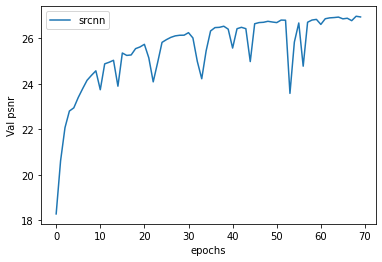

In [ ]:
plt.plot(epos_psnr_avg)     
plt.xlabel('epochs')   
plt.ylabel('Val psnr')
labels=['srcnn']
plt.legend(labels, loc = 'best')
plt.show()

In [ ]:
print('best epoch psnr: ' + str(max(epos_psnr_avg)))

best epoch psnr: 26.969995403289794


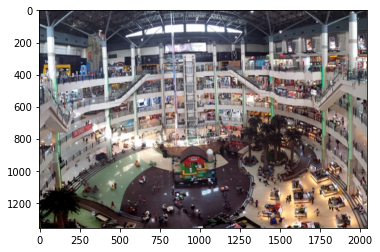

In [24]:
from PIL import Image

#To upscale low resolution images using the best saved model
#In train_model function, we saved model for the future use.
model = SRCNN(upscale_factor = 4)
model.load_state_dict(torch.load('best_model.weight'))

# If there is no 'result' directory, create one.
os.makedirs(os.path.dirname('result/'), exist_ok=True)
with torch.no_grad():  # no need to calculate gradients when assessing psnr   
    model.eval()
    predicted_hr_images = model(x_val).clamp(0, 255) 
    for indx, image in enumerate(predicted_hr_images):   # 20 images  
        img = Image.fromarray((np.array(image, dtype='uint8').transpose(1,2,0)))
        img.save('result/'+ str(indx) +'x4.png')
        
    plt.imshow(predicted_hr_images[1].type(torch.int).permute((1,2,0)))  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8.7616)
None


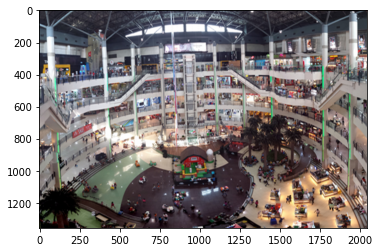

In [25]:
bic = interpolate(x_val[1][None, :].type(torch.FloatTensor), [1356, 2040], mode='bicubic', align_corners=True)[0]
print(print(compute_psnr(bic,y_val[4])))
plt.imshow(bic.type(torch.int).permute((1,2,0))) 